In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from jax import vmap
from sklearn.decomposition import PCA

In [3]:
plt.rcParams['image.cmap'] = 'hot'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

In [4]:
wf_npix = 256
oversample = 3
nslice = 3

npix = wf_npix * oversample
c = (npix - 1) / 2.
xs = (np.arange(npix, dtype=np.float64) - c) / c
XX, YY = np.meshgrid(xs, xs)
RR = np.sqrt(XX ** 2 + YY ** 2)
PHI = np.arctan2(YY, XX)

In [5]:
a = 10
b = 8
ith = 20

As = np.arange(-a, a+1)
Bs = 3 * np.arange(0, b+1)
Cs = np.array([-np.pi/2, np.pi/2])
Is = np.arange(-ith, ith+1)

LRHF_fn = lambda A, B, C, RR, PHI: np.cos(A*np.log(RR + 1e-12) + B*PHI + C)
sine_fn = lambda i, RR: np.sin(i * np.pi * RR)
cose_fn = lambda i, RR: np.cos(i * np.pi * RR)

gen_LRHF_basis = vmap(vmap(vmap(LRHF_fn, (None, 0, None, None, None)), (0, None, None, None, None)), (None, None, 0, None, None))
gen_sine_basis = vmap(sine_fn, in_axes=(0, None))
gen_cose_basis = vmap(cose_fn, in_axes=(0, None))

In [6]:
LRHF_basis = gen_LRHF_basis(As, Bs, Cs, RR, PHI).reshape([len(As)*len(Bs)*len(Cs), npix, npix])
sine_basis = gen_sine_basis(Is, RR)
cose_basis = gen_cose_basis(Is, RR)

LRHF_flat = LRHF_basis.reshape([len(As)*len(Bs)*len(Cs), npix*npix])
sine_flat = sine_basis.reshape([len(sine_basis), npix*npix])
cose_flat = cose_basis.reshape([len(cose_basis), npix*npix])

full_basis = np.concatenate([
    LRHF_flat,
    sine_flat,
    cose_flat
])

In [7]:
%%time
pca = PCA().fit(full_basis)

CPU times: user 3min 42s, sys: 3.56 s, total: 3min 45s
Wall time: 40.1 s


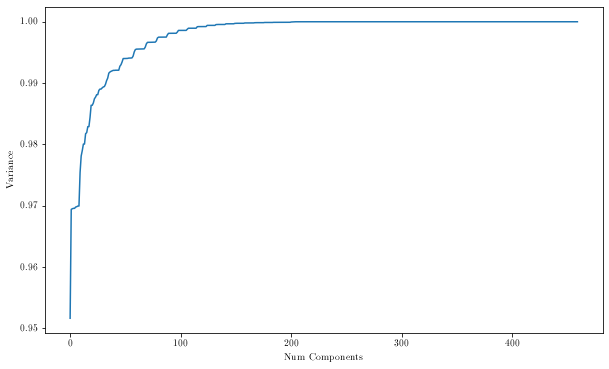

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(pca.explained_variance_ratio_)), 1 - pca.explained_variance_ratio_)
plt.xlabel("Num Components")
plt.ylabel("Variance")
plt.show()

In [9]:
mean = pca.mean_.reshape([npix, npix])
components = pca.components_.reshape([len(full_basis), npix, npix])
basis = np.append(np.array([mean]), components, axis=0)
np.save('basis', basis[:100])

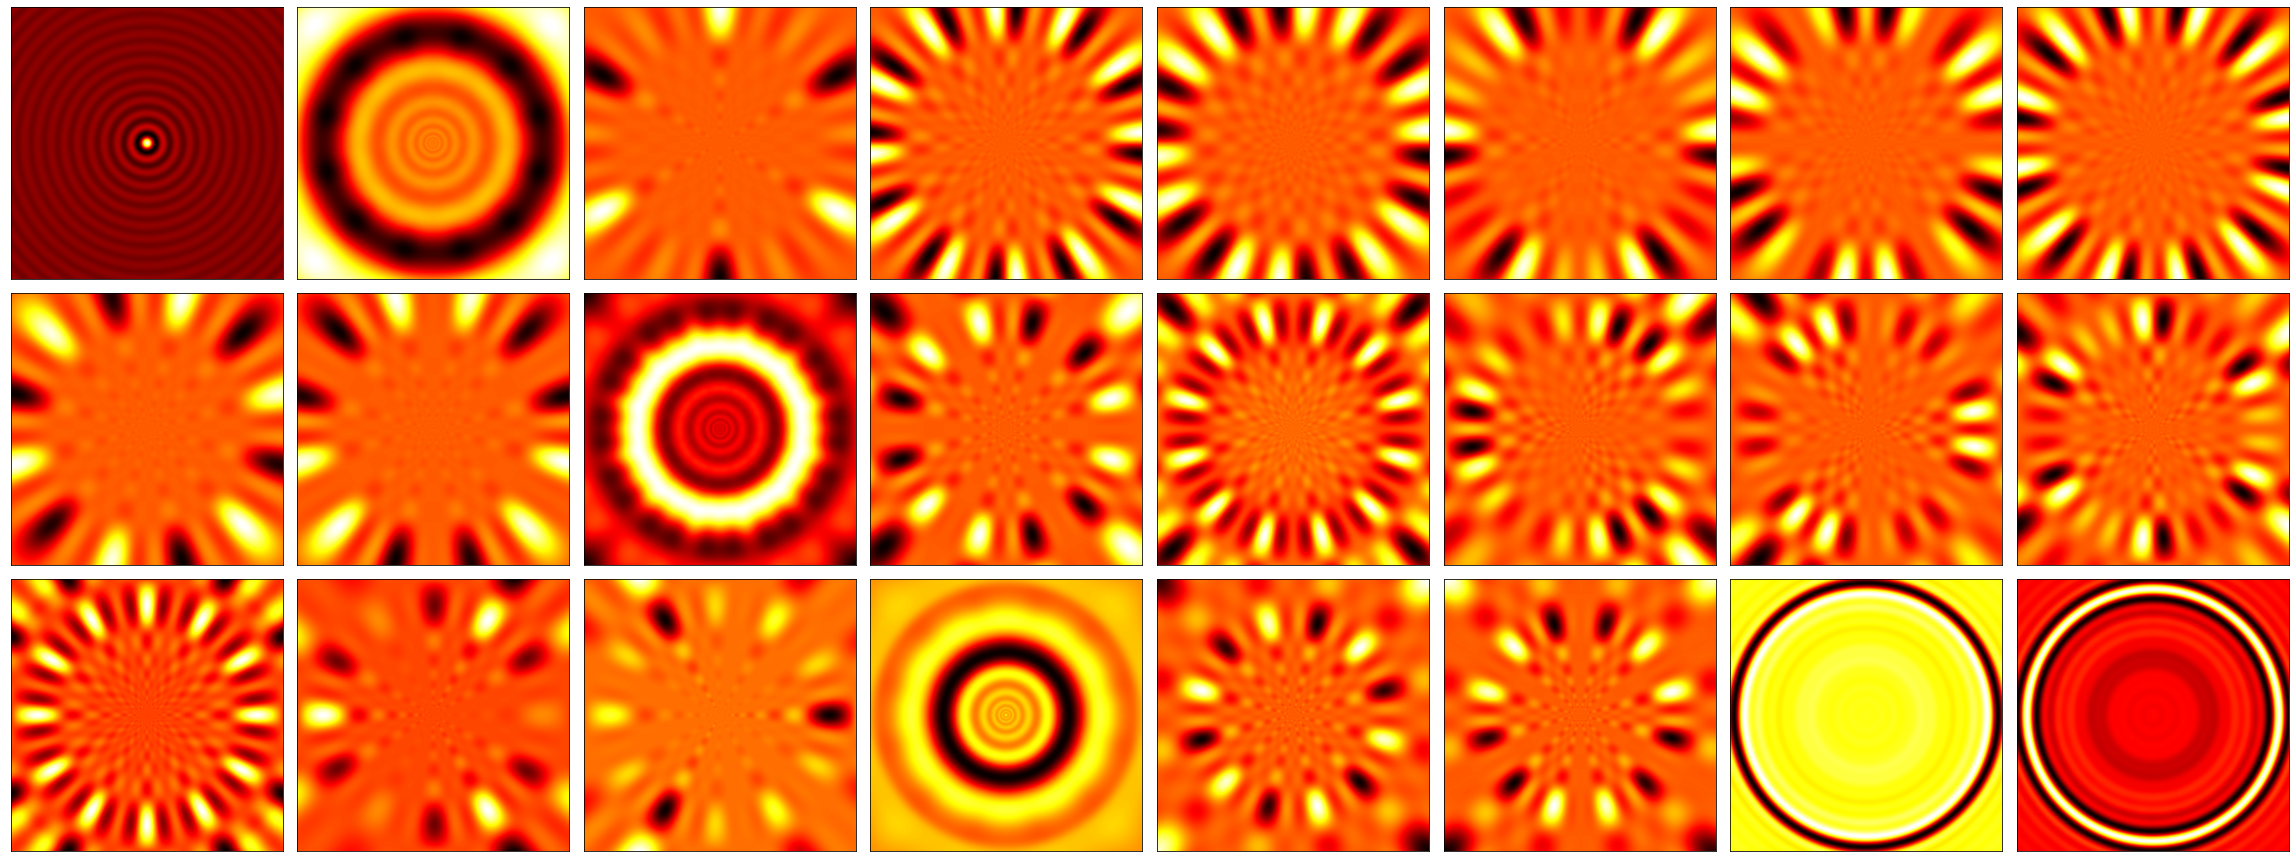

In [10]:
nfigs = 24

ncols = 8
nrows = 1 + nfigs//ncols

plt.figure(figsize=(4*ncols, 4*nrows))
# for i in range(len(components)):
for i in range(nfigs):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(basis[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.tight_layout()
plt.show()